 # Project work, part 3 - Advanced Time Series Analysis

 ## Project Links



 **Github Repository:** https://github.com/fayomitz/IND320-fayomitz

 **Streamlit app:** https://ind320-fayomitz.streamlit.app/

 ## AI Usage



 Throughout this project, AI assistance (GitHub Copilot) was utilized in several key areas:



 - **API Integration**: Assistance with understanding the open-meteo API structure, parameter configuration, and error handling for API requests

 - **Signal Processing**: Guidance on implementing Direct Cosine Transform (DCT) for high-pass filtering and calculating Seasonally Adjusted Temperature Variations (SATV)

 - **Statistical Analysis**: Help with implementing Statistical Process Control (SPC) boundaries using robust statistics (median and MAD) and configuring the Local Outlier Factor (LOF) algorithm for anomaly detection

 - **Time Series Decomposition**: Assistance with using the statsmodels STL (Seasonal-Trend decomposition using LOESS) implementation and configuring appropriate parameters

 - **Spectrogram Generation**: Guidance on using scipy's signal processing tools for Short-Time Fourier Transform (STFT) and creating meaningful spectrograms from production data

 - **Data Visualization**: Creating professional matplotlib visualizations with multiple subplots, proper axis labels, color coding for outliers/anomalies, and informative legends

 - **Function Design**: Structuring reusable functions with sensible defaults, comprehensive docstrings, and proper return values

 - **Code Documentation**: Writing detailed comments explaining each step, mathematical operations, and parameter choices



 AI tools significantly improved development efficiency, code quality, and implementation of complex signal processing and statistical methods while maintaining full understanding of the underlying algorithms.

 ## Work Log



 In this third assignment, I implemented advanced time series analysis techniques for both weather and energy production data. The work involved API integration, signal processing, anomaly detection, and spectral analysis, all wrapped in reusable functions for both Jupyter Notebook and Streamlit deployment.



 ### Jupyter Notebook Development



 #### Weather Data API Integration

 I started by creating a reference dataframe mapping Norwegian cities (Oslo, Kristiansand, Trondheim, Tromsø, Bergen) to their geographical coordinates (longitude, latitude) and corresponding electricity price areas (NO1-NO5). This provides a clear lookup table for the five main regions of Norway.



 I then developed a function to download historical weather data from the open-meteo API using the ERA5 reanalysis model. The function takes longitude, latitude, and year as inputs, constructs the appropriate API request with the same weather parameters used in part 1 (temperature, precipitation, wind speed, wind gusts, wind direction), and returns a pandas DataFrame. I tested this function by downloading 2019 data for Bergen, successfully retrieving a full year of hourly measurements.



 #### Outlier and Anomaly Detection



 For temperature analysis, I implemented a sophisticated outlier detection method combining signal processing and statistical process control. The function first plots the raw temperature time series. It then applies Direct Cosine Transform (DCT) to perform high-pass filtering, removing seasonal trends to create Seasonally Adjusted Temperature Variations (SATV). Using robust statistics (median and median absolute deviation) calculated from the SATV, the function establishes Statistical Process Control boundaries at a configurable number of standard deviations (default 3σ). Points outside these boundaries are classified as outliers and colored differently on the plot. The function is parameterized with sensible defaults for frequency cutoff and standard deviation multiplier, and returns both the plot and outlier statistics.



 For precipitation analysis, I used the Local Outlier Factor (LOF) method from scikit-learn to detect anomalies in the precipitation patterns. Unlike the temperature approach which focuses on high-frequency deviations, LOF identifies points that have significantly different local density compared to their neighbors. The function plots precipitation over time, marks anomalies identified by LOF in a contrasting color, and allows configuration of the expected outlier proportion (default 1%). This approach is well-suited for precipitation data which often has extreme values and irregular patterns.



 #### Time Series Decomposition



 I implemented a function for Seasonal-Trend decomposition using LOESS (STL) applied to the elhub production data from part 2. The function queries MongoDB to retrieve production data filtered by electricity price area and production group, then uses statsmodels' STL to decompose the time series into trend, seasonal, and residual components. All components are plotted in a multi-panel figure for easy interpretation. The function includes parameters for price area, production group, period length (seasonal period), seasonal smoother strength, trend smoother strength, and a robust flag for handling outliers. Each parameter has sensible defaults based on typical energy data patterns.



 #### Spectral Analysis



 I created a spectrogram function to visualize frequency content over time in the production data. Using scipy's Short-Time Fourier Transform (STFT), the function calculates how the frequency components of production data change throughout the year. The resulting spectrogram reveals patterns such as daily cycles, weekly patterns, or seasonal shifts in production. Parameters include price area, production group, window length (number of samples in each STFT window), and window overlap (for smooth transitions). The function produces a color-coded frequency-time plot with appropriate axis labels and color bar.



 ### Testing and Validation



 Each function was thoroughly tested with Bergen 2019 weather data and elhub production data. I verified that outlier detection correctly identified extreme weather events, that STL decomposition revealed meaningful seasonal patterns, and that spectrograms showed expected frequency components in energy production.



 ### Streamlit App Updates



 I updated the Streamlit app structure according to the specifications, reorganizing pages and adding two new pages with tabbed interfaces. Page order changed from 1-2-3-4-5 to 1-4-newA-2-3-newB-5, and the pages were given new fitting names. The CSV import was replaced with open-meteo API calls that depend on the price area selector (now on page 2) and download data from the selected year. Page "new A" uses st.tabs() with STL analysis in the first tab and Spectrogram in the second tab, both with interactive parameter controls. Page "new B" similarly uses tabs for temperature outlier/SPC analysis and precipitation anomaly/LOF analysis, with plots and summary statistics displayed for user-selected parameters.



 Throughout the project, I focused on creating production-ready code with comprehensive docstrings, proper error handling, parameterization with sensible defaults, and clear visualizations. The implementation demonstrates understanding of advanced signal processing, statistical methods, and time series analysis techniques applied to real-world weather and energy data.

 ---

 ## 1. Setup and Data Preparation

In [20]:
### Import Required Libraries ###

# Data manipulation and analysis
import pandas as pd
import numpy as np
from datetime import datetime

# API requests
import requests

# Visualization
import matplotlib.pyplot as plt

# Signal processing for DCT and spectrograms
from scipy.fft import dct, idct
from scipy import signal

# Machine learning for anomaly detection
from sklearn.neighbors import LocalOutlierFactor

# Time series decomposition
from statsmodels.tsa.seasonal import STL

# MongoDB connection (for elhub data from part 2)
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from dotenv import load_dotenv
import os

# Warnings suppression
import warnings
warnings.filterwarnings('ignore')


 ## 2. Norwegian Cities and Price Areas



 Create a reference dataframe mapping Norwegian cities to their geographical coordinates and corresponding electricity price areas.

In [21]:
### Create Norwegian Cities Reference DataFrame ###

# Define the five representative cities for Norwegian electricity price areas
# Coordinates are approximate geographical center points
cities_data = {
    'price_area': ['NO1', 'NO2', 'NO3', 'NO4', 'NO5'],
    'city': ['Oslo', 'Kristiansand', 'Trondheim', 'Tromsø', 'Bergen'],
    'latitude': [59.9139, 58.1462, 63.4305, 69.6492, 60.3913],
    'longitude': [10.7522, 7.9956, 10.3951, 18.9553, 5.3221]
}

# Create DataFrame for easy lookup
cities_df = pd.DataFrame(cities_data)

print("Norwegian Cities and Price Areas:")
print(cities_df.to_string(index=False))


Norwegian Cities and Price Areas:
price_area         city  latitude  longitude
       NO1         Oslo   59.9139    10.7522
       NO2 Kristiansand   58.1462     7.9956
       NO3    Trondheim   63.4305    10.3951
       NO4       Tromsø   69.6492    18.9553
       NO5       Bergen   60.3913     5.3221


 ## 3. Weather Data API Download Function



 Create a function to download historical weather data from open-meteo API for any location and year.

In [22]:
def download_weather_data(longitude, latitude, year):
    """
    Download historical weather data from open-meteo API using ERA5 reanalysis model.
    """
    
    # Construct API endpoint for historical data
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    
    # Define date range for the entire year
    start_date = f"{year}-01-01"
    end_date = f"{year}-12-31"
    
    # Configure API parameters to match part 1 weather variables
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'start_date': start_date,
        'end_date': end_date,
        'hourly': [
            'temperature_2m',          # Air temperature at 2m height
            'precipitation',            # Total precipitation
            'wind_speed_10m',          # Wind speed at 10m height
            'wind_gusts_10m',          # Maximum wind gusts at 10m
            'wind_direction_10m'       # Wind direction at 10m
        ],
        'timezone': 'auto'  # Use local timezone
    }
    
    # Make API request
    print(f"Downloading weather data for coordinates ({latitude}, {longitude}), year {year}...")
    response = requests.get(base_url, params=params)
    
    # Check if request was successful
    if response.status_code != 200:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")
    
    # Parse JSON response
    data = response.json()
    
    # Extract hourly data
    hourly = data['hourly']
    
    # Create DataFrame with proper column names (matching part 1 format)
    df = pd.DataFrame({
        'time': pd.to_datetime(hourly['time']),
        'temperature_2m (°C)': hourly['temperature_2m'],
        'precipitation (mm)': hourly['precipitation'],
        'wind_speed_10m (m/s)': hourly['wind_speed_10m'],
        'wind_gusts_10m (m/s)': hourly['wind_gusts_10m'],
        'wind_direction_10m (°)': hourly['wind_direction_10m']
    })
    
    print(f"Successfully downloaded {len(df)} hourly records")
    return df


 ### Test the API download function with Bergen 2019

In [23]:
# Get Bergen coordinates from our cities dataframe
bergen = cities_df[cities_df['city'] == 'Bergen'].iloc[0]
bergen_longitude = bergen['longitude']
bergen_latitude = bergen['latitude']

# Download 2019 data for Bergen
bergen_2019 = download_weather_data(bergen_longitude, bergen_latitude, 2019)

# Display basic information
print(f"\nBergen 2019 Data Summary:")
print(f"Date range: {bergen_2019['time'].min()} to {bergen_2019['time'].max()}")
print(f"\nFirst few rows:")
print(bergen_2019.head())
print(f"\nDescriptive statistics:")
print(bergen_2019.describe())


Successfully downloaded 8760 hourly records

Bergen 2019 Data Summary:
Date range: 2019-01-01 00:00:00 to 2019-12-31 23:00:00

First few rows:
                 time  temperature_2m (°C)  precipitation (mm)  \
0 2019-01-01 00:00:00                  5.7                 0.7   
1 2019-01-01 01:00:00                  5.8                 0.2   
2 2019-01-01 02:00:00                  6.1                 0.7   
3 2019-01-01 03:00:00                  6.3                 0.5   
4 2019-01-01 04:00:00                  5.8                 1.1   

   wind_speed_10m (m/s)  wind_gusts_10m (m/s)  wind_direction_10m (°)  
0                  37.0                  99.7                     263  
1                  41.0                 107.3                     278  
2                  42.0                 112.0                     286  
3                  40.9                 105.8                     298  
4                  41.2                 110.2                     315  

Descriptive statistics:
   

 ---

 ## 4. Temperature Outlier Detection using DCT and SPC



 Implement a function to detect temperature outliers using Direct Cosine Transform for high-pass filtering

 and Statistical Process Control boundaries based on robust statistics.

In [24]:
def detect_temperature_outliers(df, freq_cutoff=0.05, n_std=3):
    """
    Detect temperature outliers using DCT high-pass filtering and SPC boundaries.
    
    This function:
    1. Plots raw temperature time series
    2. Applies Direct Cosine Transform (DCT) for high-pass filtering
    3. Creates Seasonally Adjusted Temperature Variations (SATV)
    4. Calculates SPC boundaries using robust statistics (median and MAD)
    5. Identifies and colors outliers beyond the boundaries
    """
    
    # Extract temperature data and handle missing values
    temp = df['temperature_2m (°C)'].fillna(method='ffill').fillna(method='bfill').values
    time = df['time'].values
    
    # Apply Direct Cosine Transform
    temp_dct = dct(temp, type=2, norm='ortho')
    
    # Create high-pass filter by zeroing out low frequencies
    # Keep only high-frequency components (rapid changes)
    cutoff_index = int(len(temp_dct) * freq_cutoff)
    temp_dct_filtered = temp_dct.copy()
    temp_dct_filtered[:cutoff_index] = 0  # Remove seasonal and slow trends
    
    # Inverse DCT to get Seasonally Adjusted Temperature Variations (SATV)
    satv = idct(temp_dct_filtered, type=2, norm='ortho')
    
    # Calculate robust statistics for SPC boundaries
    # Use median and MAD (Median Absolute Deviation) for robustness to outliers
    median_satv = np.median(satv)
    mad_satv = np.median(np.abs(satv - median_satv))
    
    # Convert MAD to standard deviation equivalent
    # MAD * 1.4826 ≈ standard deviation for normal distribution
    std_satv = mad_satv * 1.4826
    
    # Calculate SPC boundaries
    upper_boundary = median_satv + n_std * std_satv
    lower_boundary = median_satv - n_std * std_satv
    
    # Identify outliers (SATV values outside boundaries)
    outliers_mask = (satv > upper_boundary) | (satv < lower_boundary)
    n_outliers = np.sum(outliers_mask)
    outlier_percentage = (n_outliers / len(temp)) * 100
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Plot normal temperature points in blue
    ax.plot(time[~outliers_mask], temp[~outliers_mask], 
            color='blue', linewidth=1, alpha=0.7, label='Normal temperature')
    
    # Plot outliers in red for visibility
    ax.plot(time[outliers_mask], temp[outliers_mask], 
            'o', color='red', markersize=4, alpha=0.8, label=f'Outliers (n={n_outliers})')
    
    # Plot SPC boundaries (added to original temperature for visualization)
    # Note: boundaries are calculated on SATV but shown on original scale for interpretation
    ax.axhline(y=np.mean(temp) + upper_boundary, color='orange', 
               linestyle='--', linewidth=1.5, alpha=0.7, 
               label=f'Upper boundary (+{n_std}σ)')
    ax.axhline(y=np.mean(temp) + lower_boundary, color='orange', 
               linestyle='--', linewidth=1.5, alpha=0.7, 
               label=f'Lower boundary (-{n_std}σ)')
    
    # Formatting
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Temperature (°C)', fontsize=12, fontweight='bold')
    ax.set_title(f'Temperature Outlier Detection using DCT and SPC\n' +
                 f'Frequency cutoff: {freq_cutoff}, SPC boundaries: ±{n_std}σ',
                 fontsize=14, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Prepare return dictionary
    results = {
        'figure': fig,
        'n_outliers': n_outliers,
        'outlier_percentage': outlier_percentage,
        'outlier_dates': time[outliers_mask].tolist(),
        'outlier_values': temp[outliers_mask].tolist(),
        'satv': satv,
        'upper_boundary': upper_boundary,
        'lower_boundary': lower_boundary
    }
    
    return results


 ### Test temperature outlier detection function


Temperature Outlier Detection Results
Total outliers detected: 192
Percentage of outliers: 2.19%
SATV upper boundary: 5.1494
SATV lower boundary: -5.3941

First 5 outlier dates:
  1. 1548666000000000000: -12.90°C
  2. 1548684000000000000: -1.60°C
  3. 1549112400000000000: -1.40°C
  4. 1549116000000000000: -0.50°C
  5. 1549360800000000000: -5.50°C


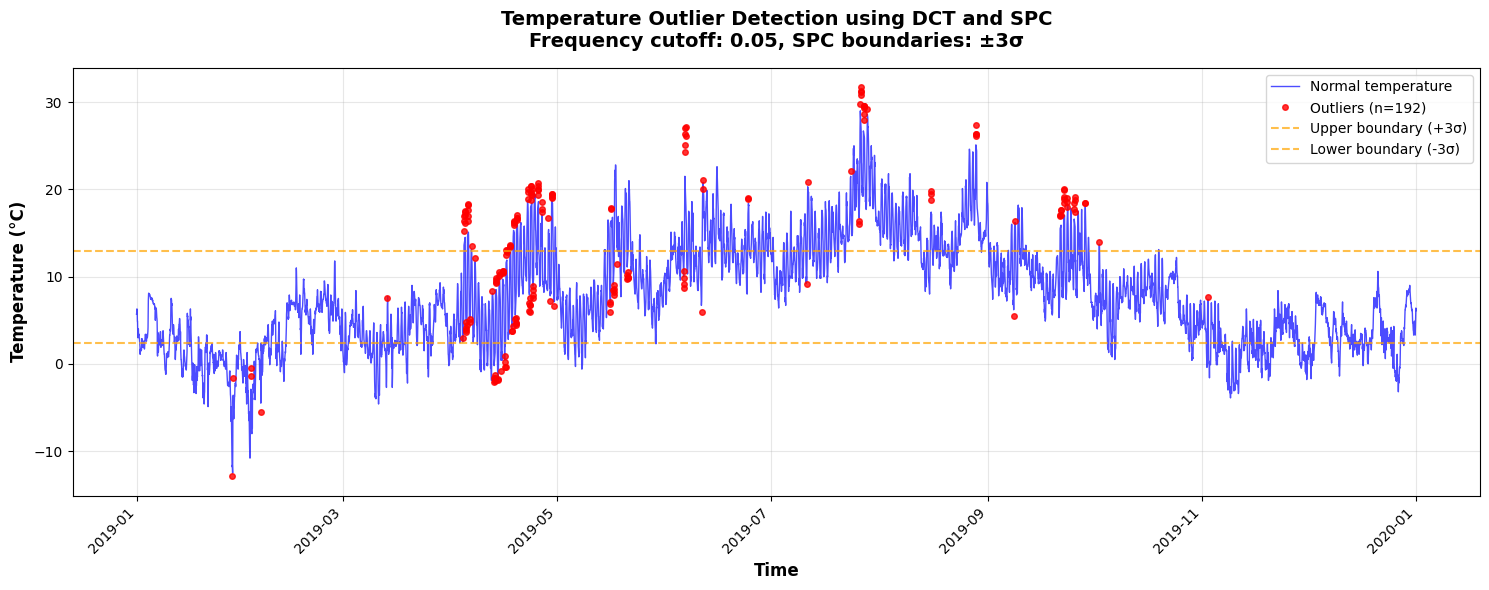

In [25]:
# Apply outlier detection to Bergen 2019 data
temp_outliers = detect_temperature_outliers(bergen_2019, freq_cutoff=0.05, n_std=3)

# Display results
print(f"\n{'='*60}")
print(f"Temperature Outlier Detection Results")
print(f"{'='*60}")
print(f"Total outliers detected: {temp_outliers['n_outliers']}")
print(f"Percentage of outliers: {temp_outliers['outlier_percentage']:.2f}%")
print(f"SATV upper boundary: {temp_outliers['upper_boundary']:.4f}")
print(f"SATV lower boundary: {temp_outliers['lower_boundary']:.4f}")

if temp_outliers['n_outliers'] > 0:
    print(f"\nFirst 5 outlier dates:")
    for i, date in enumerate(temp_outliers['outlier_dates'][:5]):
        print(f"  {i+1}. {date}: {temp_outliers['outlier_values'][i]:.2f}°C")

plt.show()


 ---

 ## 5. Precipitation Anomaly Detection using Local Outlier Factor



 Implement a function to detect precipitation anomalies using the Local Outlier Factor (LOF) method.

In [26]:
def detect_precipitation_anomalies(df, outlier_proportion=0.01):
    """
    Detect precipitation anomalies using Local Outlier Factor (LOF) method.
    
    LOF identifies anomalies based on local density deviation. Points with significantly
    lower density than their neighbors are marked as anomalies. This is well-suited for
    precipitation data which often has extreme values and irregular patterns.
    """
    
    # Extract precipitation data
    precip = df['precipitation (mm)'].values
    time = pd.to_datetime(df['time'])  # Ensure proper datetime conversion
    
    # Reshape for LOF (needs 2D array)
    # We'll use precipitation value and its rate of change as features
    precip_diff = np.diff(precip, prepend=precip[0])  # Rate of change
    X = np.column_stack([precip, precip_diff])
    
    # Initialize and fit LOF model
    # n_neighbors=20 is a common default, suitable for hourly data
    # contamination parameter specifies expected proportion of outliers
    lof = LocalOutlierFactor(n_neighbors=20, contamination=outlier_proportion)
    
    # Predict returns -1 for anomalies, 1 for normal points
    predictions = lof.fit_predict(X)
    
    # Get LOF scores (more negative = more anomalous)
    lof_scores = lof.negative_outlier_factor_
    
    # Create boolean mask for anomalies
    anomalies_mask = predictions == -1
    n_anomalies = np.sum(anomalies_mask)
    anomaly_percentage = (n_anomalies / len(precip)) * 100
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Calculate appropriate bar width based on time resolution (1 hour for hourly data)
    # Convert to matplotlib date format for proper plotting
    time_numeric = pd.to_datetime(time).to_numpy()
    
    # Plot normal precipitation in blue
    ax.bar(time_numeric[~anomalies_mask], precip[~anomalies_mask], 
           width=0.04, color='blue', alpha=0.6, label='Normal precipitation')
    
    # Plot anomalies in red with slightly wider bars for visibility
    ax.bar(time_numeric[anomalies_mask], precip[anomalies_mask], 
           width=0.04, color='red', alpha=0.8, label=f'Anomalies (n={n_anomalies})')
    
    # Formatting
    ax.set_xlabel('Time', fontsize=12, fontweight='bold')
    ax.set_ylabel('Precipitation (mm)', fontsize=12, fontweight='bold')
    ax.set_title(f'Precipitation Anomaly Detection using Local Outlier Factor (LOF)\n' +
                 f'Expected outlier proportion: {outlier_proportion*100:.1f}%',
                 fontsize=14, fontweight='bold', pad=15)
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Prepare return dictionary with properly converted datetime objects
    anomaly_dates_list = pd.to_datetime(time[anomalies_mask]).tolist()
    
    results = {
        'figure': fig,
        'n_anomalies': n_anomalies,
        'anomaly_percentage': anomaly_percentage,
        'anomaly_dates': anomaly_dates_list,
        'anomaly_values': precip[anomalies_mask].tolist(),
        'lof_scores': lof_scores
    }
    
    return results

 ### Test precipitation anomaly detection function


Precipitation Anomaly Detection Results
Total anomalies detected: 60
Percentage of anomalies: 0.68%
Mean LOF score: -2271690.5063
Min LOF score (most anomalous): -400000001.0000

Top 5 precipitation anomalies:
  1. 2019-11-06 19:00:00: 0.60 mm
  2. 2019-10-31 14:00:00: 0.60 mm
  3. 2019-12-04 13:00:00: 0.60 mm
  4. 2019-10-09 23:00:00: 0.60 mm
  5. 2019-09-27 06:00:00: 0.60 mm


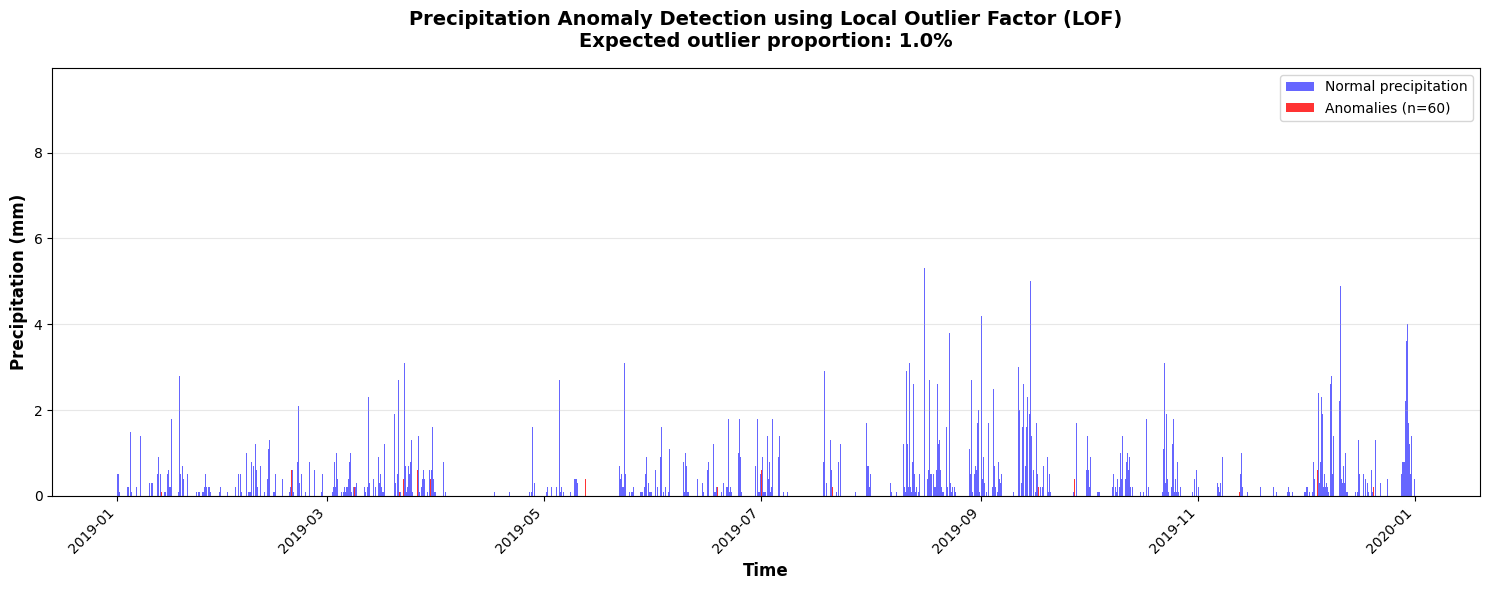

In [27]:
# Apply anomaly detection to Bergen 2019 data
precip_anomalies = detect_precipitation_anomalies(bergen_2019, outlier_proportion=0.01)

# Display results
print(f"\n{'='*60}")
print(f"Precipitation Anomaly Detection Results")
print(f"{'='*60}")
print(f"Total anomalies detected: {precip_anomalies['n_anomalies']}")
print(f"Percentage of anomalies: {precip_anomalies['anomaly_percentage']:.2f}%")
print(f"Mean LOF score: {np.mean(precip_anomalies['lof_scores']):.4f}")
print(f"Min LOF score (most anomalous): {np.min(precip_anomalies['lof_scores']):.4f}")

if precip_anomalies['n_anomalies'] > 0:
    print(f"\nTop 5 precipitation anomalies:")
    # Sort by value to show highest anomalies
    sorted_indices = np.argsort(precip_anomalies['anomaly_values'])[::-1]
    for i, idx in enumerate(sorted_indices[:5]):
        print(f"  {i+1}. {precip_anomalies['anomaly_dates'][idx]}: {precip_anomalies['anomaly_values'][idx]:.2f} mm")

plt.show()


 ---

 ## 6. STL Decomposition for Elhub Production Data



 Implement Seasonal-Trend decomposition using LOESS (STL) for electricity production data.

In [28]:
def stl_decomposition(price_area='NO5', production_group='hydro', 
                     period=24, seasonal=7, trend=None, robust=False):
    """
    Perform STL (Seasonal-Trend decomposition using LOESS) on elhub production data.
    
    STL decomposes a time series into three components:
    - Trend: Long-term progression of the series
    - Seasonal: Repeating patterns (daily, weekly, etc.)
    - Residual: Remainder after removing trend and seasonal components
    """
    
    # Load environment variables for MongoDB connection
    load_dotenv()
    uri = os.getenv("URI")
    
    if uri is None:
        raise ValueError("MongoDB URI not found. Please set URI in .env file")
    
    # Connect to MongoDB
    client = MongoClient(uri, server_api=ServerApi('1'))
    db = client['energy_data']
    collection = db['production']
    
    # Query data for specified price area and production group
    query = {
        'priceArea': price_area,
        'productionGroup': production_group
    }
    
    print(f"Querying MongoDB for {production_group} production in {price_area}...")
    cursor = collection.find(query).sort('startTime', 1)  # Sort by time
    data = list(cursor)
    
    if len(data) == 0:
        raise ValueError(f"No data found for {production_group} in {price_area}")
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['startTime'] = pd.to_datetime(df['startTime'], utc=True)
    df = df.sort_values('startTime')
    
    # Create time series
    ts = pd.Series(
        df['quantityKwh'].values,
        index=df['startTime']
    )
    
    print(f"Loaded {len(ts)} records from {ts.index.min()} to {ts.index.max()}")
    
    # Handle missing values
    ts = ts.fillna(method='ffill').fillna(method='bfill')
    
    # Perform STL decomposition
    print(f"Performing STL decomposition (period={period}, seasonal={seasonal}, robust={robust})...")
    stl = STL(ts, period=period, seasonal=seasonal, trend=trend, robust=robust)
    result = stl.fit()
    
    # Create visualization with 4 subplots
    fig, axes = plt.subplots(4, 1, figsize=(15, 10))
    
    # Plot original data
    axes[0].plot(ts.index, ts.values, color='black', linewidth=1)
    axes[0].set_ylabel('Original', fontsize=11, fontweight='bold')
    axes[0].set_title(f'STL Decomposition: {production_group} in {price_area}', 
                     fontsize=14, fontweight='bold', pad=15)
    axes[0].grid(True, alpha=0.3)
    
    # Plot trend component
    axes[1].plot(ts.index, result.trend, color='blue', linewidth=1.5)
    axes[1].set_ylabel('Trend', fontsize=11, fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    # Plot seasonal component
    axes[2].plot(ts.index, result.seasonal, color='green', linewidth=1)
    axes[2].set_ylabel('Seasonal', fontsize=11, fontweight='bold')
    axes[2].grid(True, alpha=0.3)
    
    # Plot residual component
    axes[3].plot(ts.index, result.resid, color='red', linewidth=1)
    axes[3].set_ylabel('Residual', fontsize=11, fontweight='bold')
    axes[3].set_xlabel('Time', fontsize=12, fontweight='bold')
    axes[3].grid(True, alpha=0.3)
    
    # Format x-axis
    for ax in axes:
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    
    # Prepare return dictionary
    results = {
        'figure': fig,
        'stl_result': result,
        'trend': result.trend.values,
        'seasonal': result.seasonal.values,
        'residual': result.resid.values
    }
    
    return results


 ### Test STL decomposition function

Querying MongoDB for hydro production in NO5...
Loaded 8760 records from 2020-12-31 23:00:00+00:00 to 2021-12-31 22:00:00+00:00
Performing STL decomposition (period=24, seasonal=7, robust=True)...

STL Decomposition Results
Trend component - Mean: 3496560.76, Std: 1066269.22
Seasonal component - Mean: -202.55, Std: 569058.49
Residual component - Mean: -33245.47, Std: 460066.69


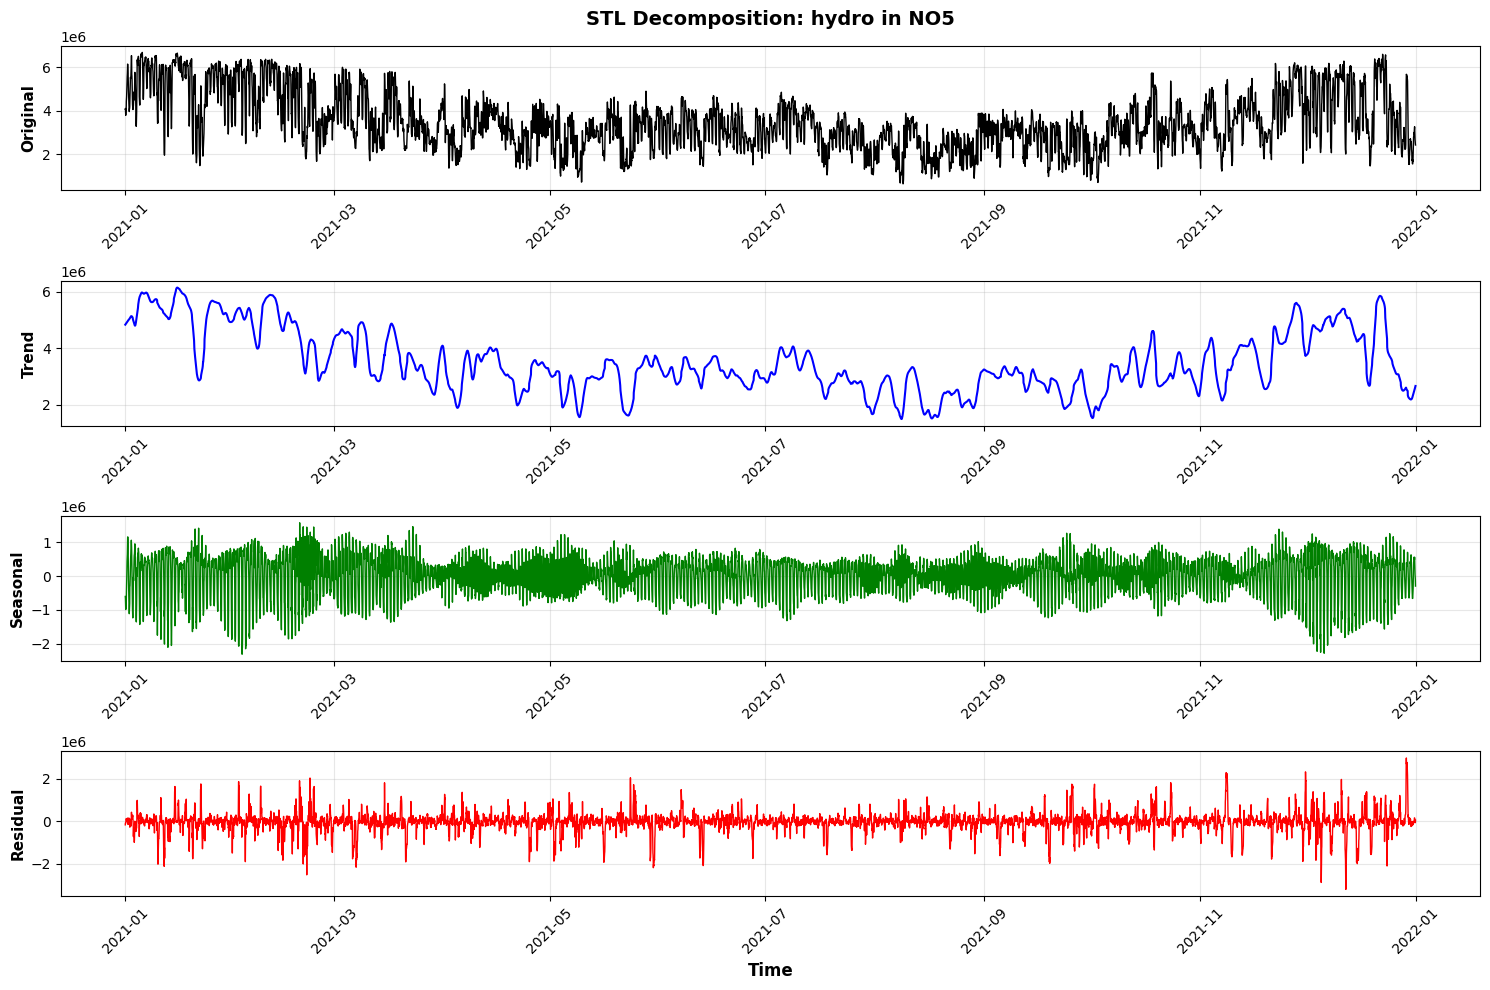

In [29]:
# Apply STL decomposition to Bergen/NO5 hydro production
stl_results = stl_decomposition(
    price_area='NO5',
    production_group='hydro',
    period=24,        # Daily seasonality for hourly data
    seasonal=7,       # Moderate seasonal smoothing
    trend=None,       # Auto-calculate trend smoother
    robust=True       # Use robust fitting for outliers
)

print(f"\n{'='*60}")
print(f"STL Decomposition Results")
print(f"{'='*60}")
print(f"Trend component - Mean: {np.mean(stl_results['trend']):.2f}, Std: {np.std(stl_results['trend']):.2f}")
print(f"Seasonal component - Mean: {np.mean(stl_results['seasonal']):.2f}, Std: {np.std(stl_results['seasonal']):.2f}")
print(f"Residual component - Mean: {np.mean(stl_results['residual']):.2f}, Std: {np.std(stl_results['residual']):.2f}")

plt.show()


 ---

 ## 7. Spectrogram for Elhub Production Data



 Create a spectrogram to visualize frequency components over time in electricity production data.

In [30]:
def create_spectrogram(price_area='NO5', production_group='hydro', 
                      window_length=256, window_overlap=128):
    """
    Create a spectrogram of elhub production data using Short-Time Fourier Transform (STFT).
    
    A spectrogram shows how the frequency content of a signal changes over time,
    revealing patterns such as daily cycles, weekly patterns, or seasonal shifts.
    """
    
    # Load environment variables for MongoDB connection
    load_dotenv()
    uri = os.getenv("URI")
    
    if uri is None:
        raise ValueError("MongoDB URI not found. Please set URI in .env file")
    
    # Connect to MongoDB
    client = MongoClient(uri, server_api=ServerApi('1'))
    db = client['energy_data']
    collection = db['production']
    
    # Query data for specified price area and production group
    query = {
        'priceArea': price_area,
        'productionGroup': production_group
    }
    
    print(f"Querying MongoDB for {production_group} production in {price_area}...")
    cursor = collection.find(query).sort('startTime', 1)
    data = list(cursor)
    
    if len(data) == 0:
        raise ValueError(f"No data found for {production_group} in {price_area}")
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    df['startTime'] = pd.to_datetime(df['startTime'], utc=True)
    df = df.sort_values('startTime')
    
    # Extract production values
    production = df['quantityKwh'].values
    
    # Handle missing values
    production = pd.Series(production).fillna(method='ffill').fillna(method='bfill').values
    
    print(f"Loaded {len(production)} records")
    print(f"Creating spectrogram (window_length={window_length}, overlap={window_overlap})...")
    
    # Compute Short-Time Fourier Transform (STFT)
    # fs=1 means sampling rate of 1 sample per hour (for hourly data)
    frequencies, times, Sxx = signal.spectrogram(
        production,
        fs=1.0,                          # Sampling frequency (1 sample per hour)
        window='hann',                    # Hann window reduces spectral leakage
        nperseg=window_length,            # Samples per segment
        noverlap=window_overlap           # Overlapping samples
    )
    
    # Convert power to dB scale for better visualization
    Sxx_db = 10 * np.log10(Sxx + 1e-10)  # Add small constant to avoid log(0)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot spectrogram as a heatmap
    im = ax.pcolormesh(
        times,                  # X-axis: time (in hours from start)
        frequencies,            # Y-axis: frequency (cycles per hour)
        Sxx_db,                # Color: spectral power in dB
        shading='gouraud',     # Smooth shading
        cmap='viridis'         # Color map
    )
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, label='Power (dB)')
    
    # Formatting
    ax.set_xlabel('Time (hours from start)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Frequency (cycles/hour)', fontsize=12, fontweight='bold')
    ax.set_title(f'Spectrogram: {production_group} Production in {price_area}\n' +
                 f'Window length: {window_length} hours, Overlap: {window_overlap} hours',
                 fontsize=14, fontweight='bold', pad=15)
    
    # Add grid
    ax.grid(True, alpha=0.3, color='white', linewidth=0.5)
    
    plt.tight_layout()
    
    # Prepare return dictionary
    results = {
        'figure': fig,
        'frequencies': frequencies,
        'times': times,
        'spectrogram': Sxx_db
    }
    
    return results


 ### Test spectrogram function

Querying MongoDB for hydro production in NO5...
Loaded 8760 records
Creating spectrogram (window_length=168, overlap=84)...

Spectrogram Results
Frequency range: 0.000000 to 0.500000 cycles/hour
Time range: 84.0 to 8652.0 hours
Spectrogram shape: (85, 103) (frequencies x times)

Key frequency interpretations:
  1/24 = 0.041667 cycles/hour → Daily cycle
  1/168 = 0.005952 cycles/hour → Weekly cycle
  1/720 = 0.001389 cycles/hour → Monthly cycle (approx)


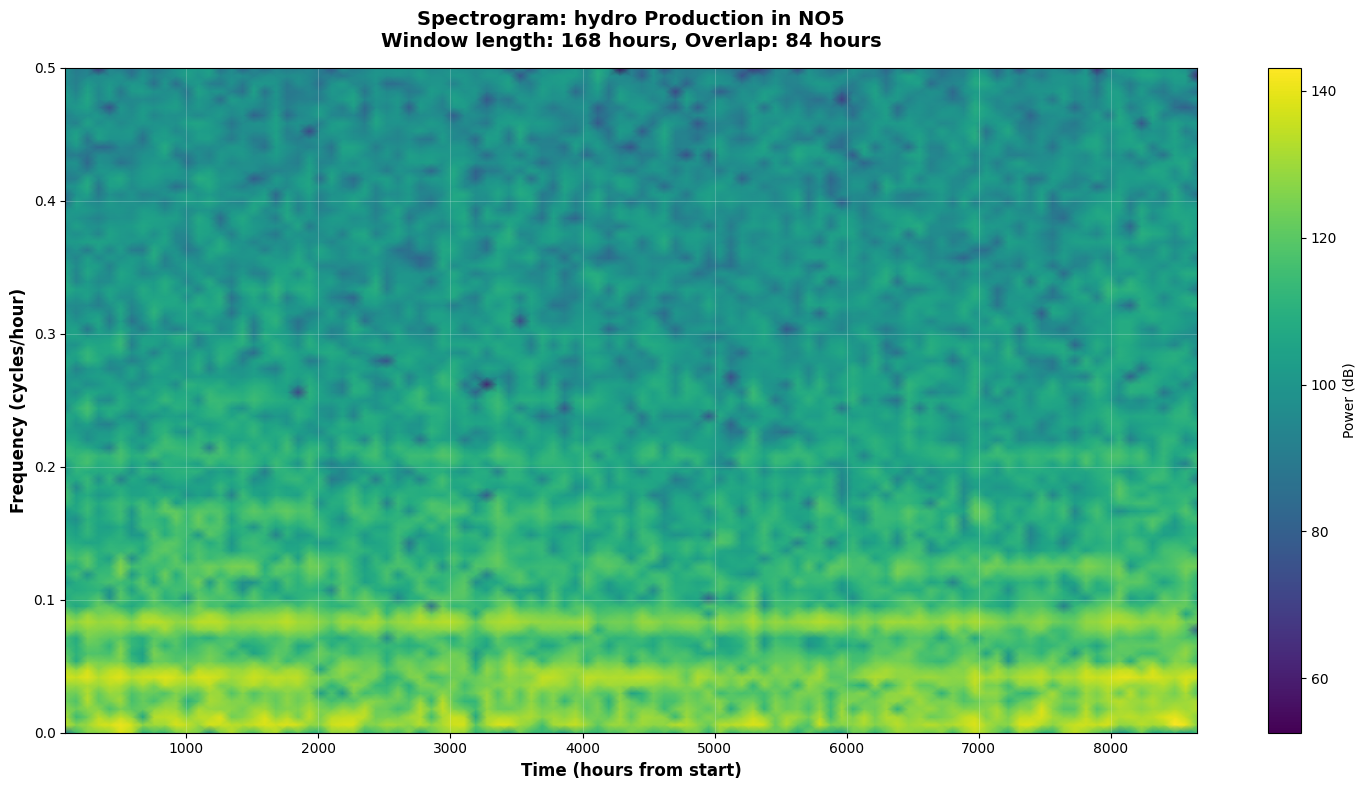

In [31]:
# Create spectrogram for Bergen/NO5 hydro production
# Using window length of 168 hours (1 week) to capture weekly patterns
spectrogram_results = create_spectrogram(
    price_area='NO5',
    production_group='hydro',
    window_length=168,    # 1 week window for weekly patterns
    window_overlap=84     # 50% overlap
)

print(f"\n{'='*60}")
print(f"Spectrogram Results")
print(f"{'='*60}")
print(f"Frequency range: {spectrogram_results['frequencies'].min():.6f} to {spectrogram_results['frequencies'].max():.6f} cycles/hour")
print(f"Time range: {spectrogram_results['times'].min():.1f} to {spectrogram_results['times'].max():.1f} hours")
print(f"Spectrogram shape: {spectrogram_results['spectrogram'].shape} (frequencies x times)")

# Interpret key frequencies
print(f"\nKey frequency interpretations:")
print(f"  1/24 = {1/24:.6f} cycles/hour → Daily cycle")
print(f"  1/168 = {1/168:.6f} cycles/hour → Weekly cycle")
print(f"  1/720 = {1/720:.6f} cycles/hour → Monthly cycle (approx)")

plt.show()
